In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import matplotlib.pyplot as plt
import shapely.geometry as shg
import numpy as np
from shapely.affinity import translate

In [3]:
img_url = '/fastdata/tmp/SB001-T01-01-HE.ome.tiff'

In [4]:
from cpath.core.wsi import WSIInfo
from cpath.core.mask import mask_to_external_contours
from cpath.proc.tissue_he import detect_foreground
from cpath.core import NumpyJSONEncoder
from cpath.core.mri import MRI
from cpath.core.annot import WSIAnnotation

In [5]:
wsi = WSIInfo(img_url)
img_src = MRI(wsi)
WORK_MPP_1 = 15.0  # mpp
WORK_MPP_2 = 1.8   # mpp
min_obj_size = {'15.0': 1500, '3.75': 50000, '1.8': 100000, '0.9': 500000}

In [7]:
level_1 = wsi.get_level_for_mpp(WORK_MPP_1)
img = img_src.get_plane(level=level_1)
mask, _ = detect_foreground(img, method='fesi', 
                            min_area=min_obj_size[str(WORK_MPP_1)])
contours = mask_to_external_contours(mask, approx_factor=0.0001, 
                                     min_area=min_obj_size[str(WORK_MPP_1)])

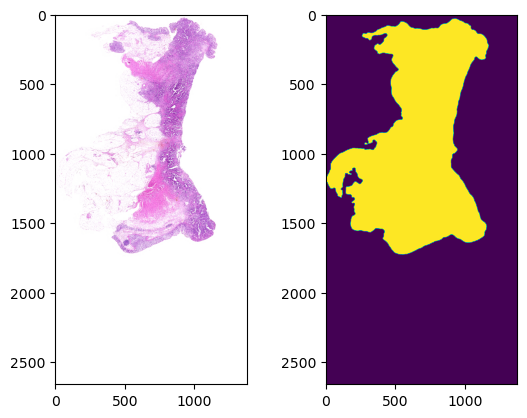

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(img)
ax2.imshow(mask)

In [12]:
len(contours)

1

In [14]:
# find the bounding box of the contours:
xmin, ymin = img.shape[:2]
xmax, ymax = 0, 0
for c in contours:
    minx, miny, maxx, maxy = c.geom.bounds
    xmin = min(xmin, minx)
    ymin = min(ymin, miny)
    xmax = max(xmax, maxx)
    ymax = max(ymax, maxy)

In [63]:
print(xmin, xmax, ymin, ymax)

0.0 1167.0 32.0 1727.0


In [15]:
level_2 = wsi.get_level_for_mpp(WORK_MPP_2)
f = 2**(int(level_1 - level_2))

In [16]:
f

8

In [17]:
xmin = int(f * max(0, xmin - 5))
ymin = int(f * max(0, ymin - 5))
xmax = int(f * min(img.shape[1] - 1, xmax + 5))
ymax = int(f * min(img.shape[0] - 1, ymax + 5))
print(xmin, ymin, xmax, ymax)

0 216 9376 13856


In [18]:
# print("ROI @{}x: {},{} -> {},{}".format(WORK_MAG_2, xmin, ymin, xmax, ymax))
img = img_src.get_region_px(xmin, ymin,
                            width=xmax - xmin, height=ymax - ymin,
                            level=level_2, as_type=np.uint8)


In [19]:
img.shape

(13640, 9376, 3)

In [32]:
#mask, _ = detect_foreground(img, method='simple-he', 
#                            min_area=min_obj_size[str(WORK_MPP_2)])
mask, _ = detect_foreground(img, method='fesi',
                            laplace_ker=15, gauss_ker=17, gauss_sigma=25.0,
                            morph_open_ker=5, morph_open_iter=7, morph_blur=17,
                            min_area=min_obj_size[str(WORK_MPP_2)])

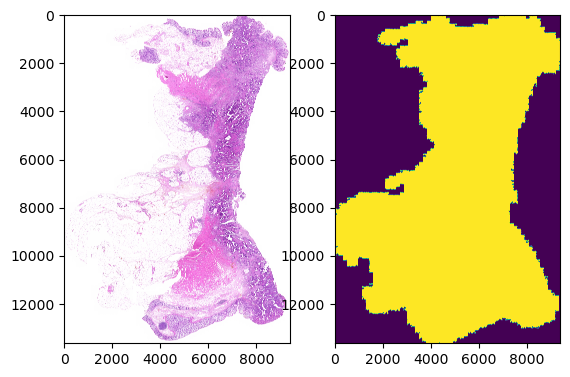

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(img)
ax2.imshow(mask)

In [34]:
contours = mask_to_external_contours(mask,
                                     approx_factor=0.0005,
                                     min_area=min_obj_size[str(WORK_MPP_2)])

# don't forget to shift detections by (xmin, ymin) to obtain coords in original space for
# this magnification level...
for c in contours:
    c.geom = translate(c.geom, xoff=xmin, yoff=ymin)
    c._name = "tissue"

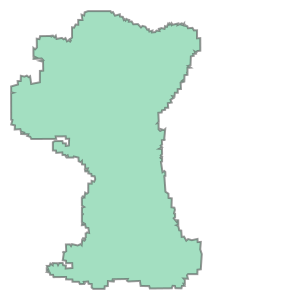

In [35]:
contours[0].geom